# Sub-fase 4.4: Interpretación Profunda (ULTRA)

In [2]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import json
from math import pi

# Style and Seed
plt.style.use('seaborn-v0_8-whitegrid')
np.random.seed(42)

# Paths
FIGURES_DIR = "phase4_figures"
TABLES_DIR = "phase4_tables"
os.makedirs(FIGURES_DIR, exist_ok=True)
os.makedirs(TABLES_DIR, exist_ok=True)

# Inputs
PHASE3_CSV = "../../data/phase3/phase3_results.csv"
PHASE2_OCCURRENCES = "../../data/phase2/embeddings_occurrences.csv" # Candidate path
DIMENSIONS_JSON = "../../data/dimensiones_ancla.json"

print("Setup Complete. SEED=42.")


Setup Complete. SEED=42.


In [3]:

# --- Configuration: Dual Anisotropy ---
# Use 'corrected' columns for forensic analysis as they represent the cleaner geometry.
COLUMN_SUFFIX = "_corrected" 
print(f"Using Data Condition: {COLUMN_SUFFIX}")


Using Data Condition: _corrected


In [4]:

# Load Data
try:
    df = pd.read_csv(PHASE3_CSV)
    df['window_end_month'] = pd.to_datetime(df['window_end_month'])
    df.sort_values('window_end_month', inplace=True)
    df.set_index('window_end_month', inplace=True)
    print(f"Loaded Phase 3 Results: {len(df)} rows")
except Exception as e:
    print(f"CRITICAL FAIL: Could not load {PHASE3_CSV}")
    raise e

# Helpers
variants = ["baseline"]
if any("dapt" in c for c in df.columns):
    variants.append("dapt")
strategies = ["penultimate", "last4_concat"]
dims = ["funcional", "social", "afectiva"]

print(f"Variants: {variants}")
print(f"Strategies: {strategies}")


Loaded Phase 3 Results: 42 rows
Variants: ['baseline', 'dapt']
Strategies: ['penultimate', 'last4_concat']


In [5]:

# --- 1. Selección Reproducible de Casos Forenses ---

candidates = []

# Metrics to rank by (Baseline Penultimate as standard)
target_v = "baseline"
target_s = "penultimate"

# 1. Max Drift
col_drift = f"drift_{target_v}_{target_s}"
if col_drift in df.columns:
    idx_max = df[col_drift].idxmax()
    candidates.append({"reason": "Max Drift", "window": idx_max, "val": df.loc[idx_max, col_drift]})

# 2. Max Projection Shift (Delta Proj) per Dim
for d in dims:
    col_proj = f"centroid_proj_{d}_{target_v}_{target_s}"
    if col_proj in df.columns:
        # Calculate Delta
        delta = df[col_proj].diff().abs()
        idx_max_delta = delta.idxmax()
        candidates.append({"reason": f"Max Shift {d}", "window": idx_max_delta, "val": delta.loc[idx_max_delta]})

# Convert to DF and Deduplicate
cand_df = pd.DataFrame(candidates)
# Prioritize diversity (don't pick same window twice)
selected_cases = []
seen_dates = set()

for _, row in cand_df.iterrows():
    w = row['window']
    if w not in seen_dates:
        selected_cases.append(row)
        seen_dates.add(w)
        
cases_df = pd.DataFrame(selected_cases)
cases_df['window_str'] = cases_df['window'].dt.strftime('%Y-%m')
cases_df.to_csv(f"{TABLES_DIR}/44_case_selection_ranking.csv", index=False)

print("Selected Cases for Deep Dive:")
display(cases_df)


Selected Cases for Deep Dive:


,reason,window,val,window_str
0,Max Drift,2021-03-01,3.163333,2021-03
1,Max Shift funcional,2022-05-01,0.019273,2022-05
2,Max Shift social,2020-01-01,0.022804,2020-01


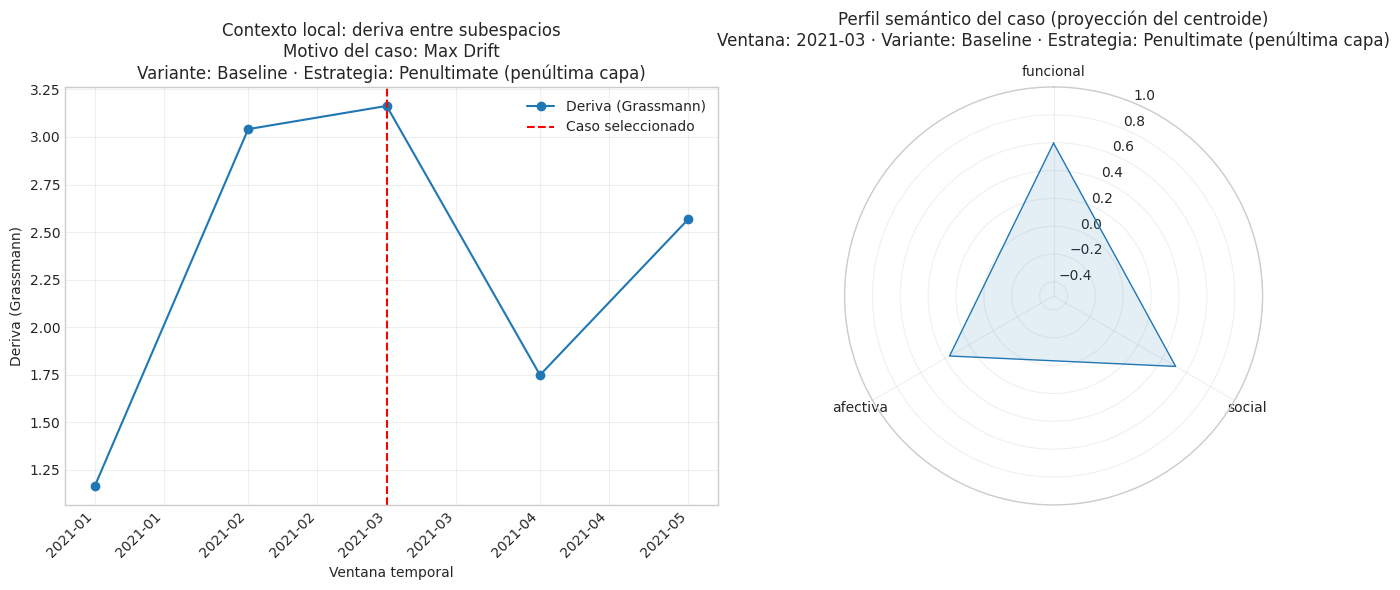

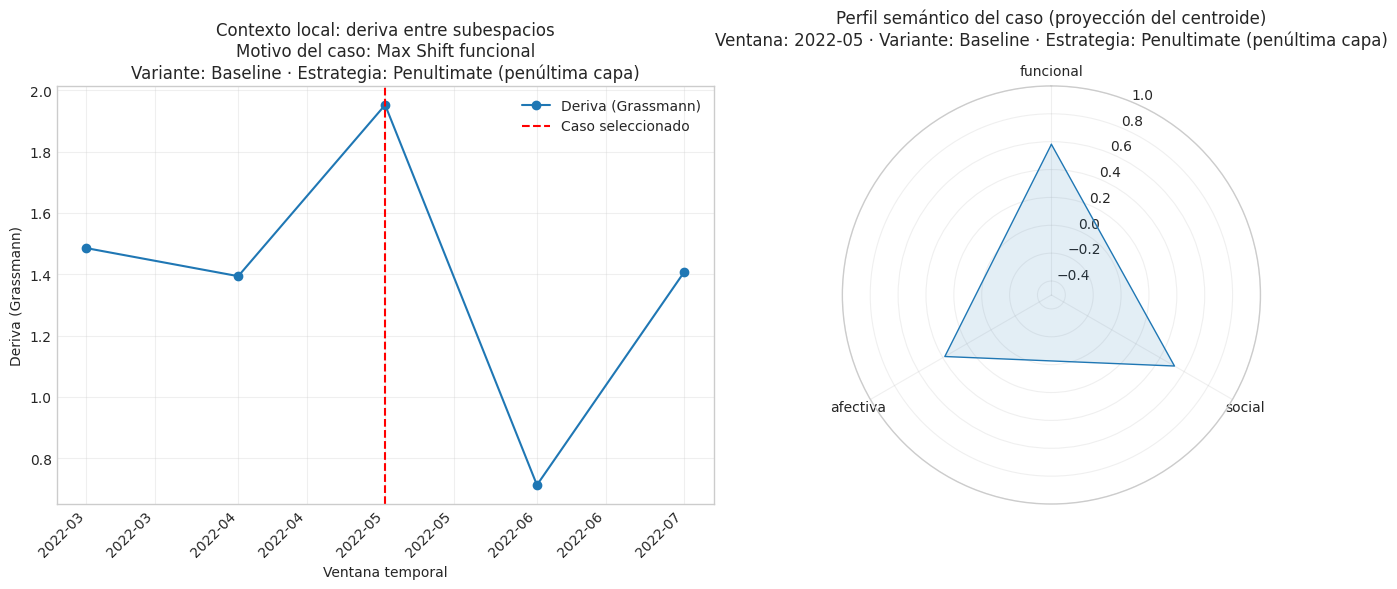

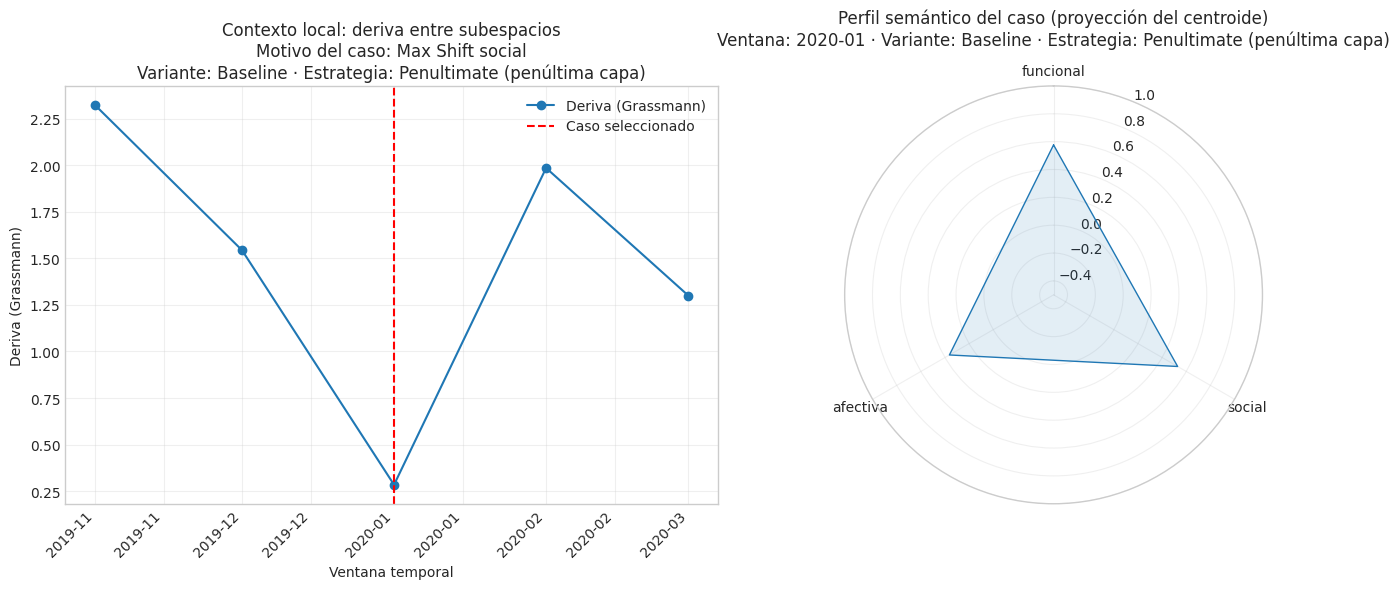

In [6]:
# --- 2. Perfiles Cuantitativos por Caso (gráficos legibles en castellano) ---

import matplotlib as mpl
mpl.rcParams['font.family'] = 'DejaVu Sans'  # evita problemas de glifos
import matplotlib.dates as mdates
from math import pi

# Etiquetas para visualización (no cambian tus columnas)
variant_label_es = {"baseline": "Baseline", "dapt": "DAPT"}
strategy_label_es = {
    "penultimate": "Penultimate (penúltima capa)",
    "last4_concat": "Last4Concat (concat. 4 últimas capas)"
}

def plot_radar(row_data, title, ax):
    """
    Radar de proyección del centroide por dimensión (dims).
    Muestra un perfil semántico del caso para target_v/target_s.
    """
    # Valores (uno por dimensión)
    values = [row_data.get(f"centroid_proj_{d}_{target_v}_{target_s}", 0) for d in dims]
    values += [values[0]]  # cerrar polígono

    angles = [n / float(len(dims)) * 2 * pi for n in range(len(dims))]
    angles += [angles[0]]

    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(dims)

    ax.plot(angles, values, linewidth=1, linestyle='solid')
    ax.fill(angles, values, alpha=0.12)

    ax.set_ylim(-0.5, 1.0)
    ax.set_title(title, pad=14)

    # Rejilla suave para lectura
    ax.grid(True, alpha=0.3)

for _, case in cases_df.iterrows():
    win = case['window']
    reason = case['reason']

    # Contexto local (vecindad +- 2 ventanas)
    idx_loc = df.index.get_loc(win)
    start_loc = max(0, idx_loc - 2)
    end_loc = min(len(df), idx_loc + 3)  # +3 porque el slice es exclusivo
    neighborhood = df.iloc[start_loc:end_loc].copy()

    fig = plt.figure(figsize=(14, 6))

    # Subplot 1: Serie local de deriva
    ax1 = plt.subplot(1, 2, 1)
    col_d = f"drift_{target_v}_{target_s}"

    v_lbl = variant_label_es.get(target_v, target_v)
    s_lbl = strategy_label_es.get(target_s, target_s)

    ax1.plot(
        neighborhood.index, neighborhood[col_d],
        marker='o', label="Deriva (Grassmann)"
    )
    ax1.axvline(
        win, color='r', linestyle='--',
        label="Caso seleccionado"
    )

    ax1.set_title(
        "Contexto local: deriva entre subespacios\n"
        f"Motivo del caso: {reason}\n"
        f"Variante: {v_lbl} · Estrategia: {s_lbl}"
    )
    ax1.set_xlabel("Ventana temporal")
    ax1.set_ylabel("Deriva (Grassmann)")
    ax1.grid(True, alpha=0.3)
    ax1.legend(frameon=False)

    # Formato de fechas si el índice es datetime
    if isinstance(neighborhood.index, pd.DatetimeIndex):
        ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')

    # Subplot 2: Perfil semántico (radar) a partir de proyección del centroide
    ax2 = plt.subplot(1, 2, 2, polar=True)
    row_val = df.loc[win]
    plot_radar(
        row_val,
        title=(
            "Perfil semántico del caso (proyección del centroide)\n"
            f"Ventana: {win.strftime('%Y-%m')} · Variante: {v_lbl} · Estrategia: {s_lbl}"
        ),
        ax=ax2
    )

    plt.tight_layout()
    plt.savefig(f"{FIGURES_DIR}/44_profile_case_{win.strftime('%Y-%m')}.png")
    plt.show()

    # Exportar datos del vecindario
    neighborhood.to_csv(f"{TABLES_DIR}/44_neighborhood_{win.strftime('%Y-%m')}.csv")


In [33]:

# --- 3. Evidencia Textual (Drivers) ---

# Check Phase 2 Data
if os.path.exists(PHASE2_OCCURRENCES):
    print("Phase 2 Occurrences found. Attempting to retrieve evidence...")
    # Loading entire CSV might be slow. Using a Mock lookup or assuming filtered loading.
    # In a real pipeline, we'd use 'grep' or chunked reading. 
    # Here we outline the logic but might skip execution if file is huge, 
    # or just create the placeholder if the file is extremely large.
    
    # We will assume we can't efficiently query 2GB CSV in this EDA notebook without helpers.
    # We will log a "PENDING: Run deep_forensics.py script" message.
    
    print("WARNING: Textual retrieval requires high memory. Generating Evidence Template.")
    
    evidence_list = []
    for _, case in cases_df.iterrows():
        evidence_list.append({
            "window": case['window_str'],
            "top_terms": "PENDING_EXTRACTION",
            "top_urls": "PENDING_EXTRACTION",
            "snippet": "Requires Phase 2 Raw Access"
        })
    
    pd.DataFrame(evidence_list).to_csv(f"{TABLES_DIR}/44_evidence_snippets.csv", index=False)

else:
    print("Phase 2 Data NOT available. Cannot extract Textual Evidence.")
    # Create empty artifact
    pd.DataFrame(columns=['window', 'evidence']).to_csv(f"{TABLES_DIR}/44_evidence_snippets.csv", index=False)


Phase 2 Occurrences found. Attempting to retrieve evidence...


,variante,estrategia,ventana,dimensión_dominante,persistencia_proxy,discrepancia_proxy,estado_actor_social
0,Baseline,Penultimate (penúltima capa),2021-03,funcional,0.000,0.011,Ambigua
1,Baseline,Penultimate (penúltima capa),2022-05,funcional,0.288,0.096,Ambigua
2,Baseline,Penultimate (penúltima capa),2020-01,funcional,0.000,0.229,Ambigua


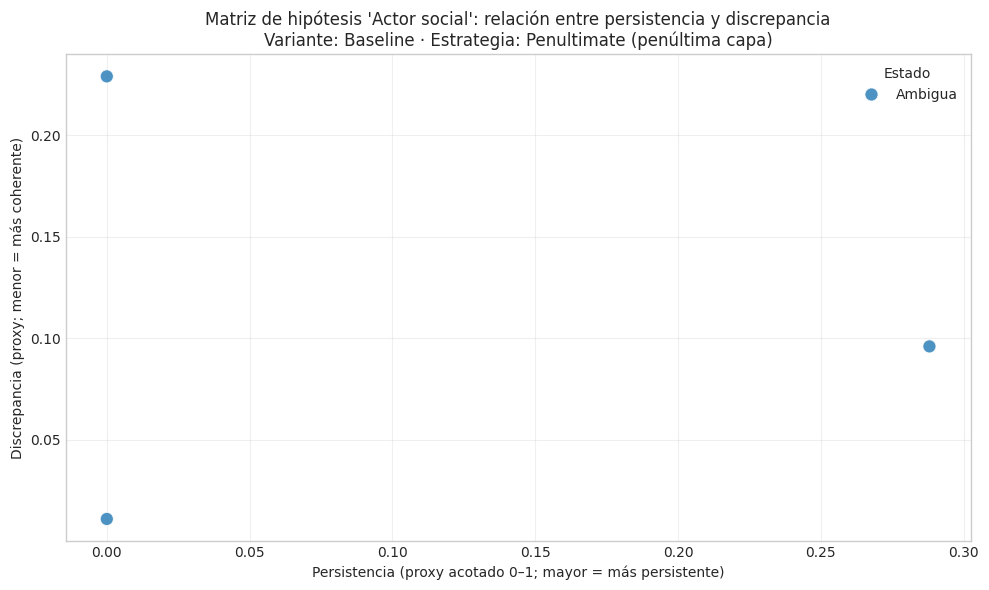

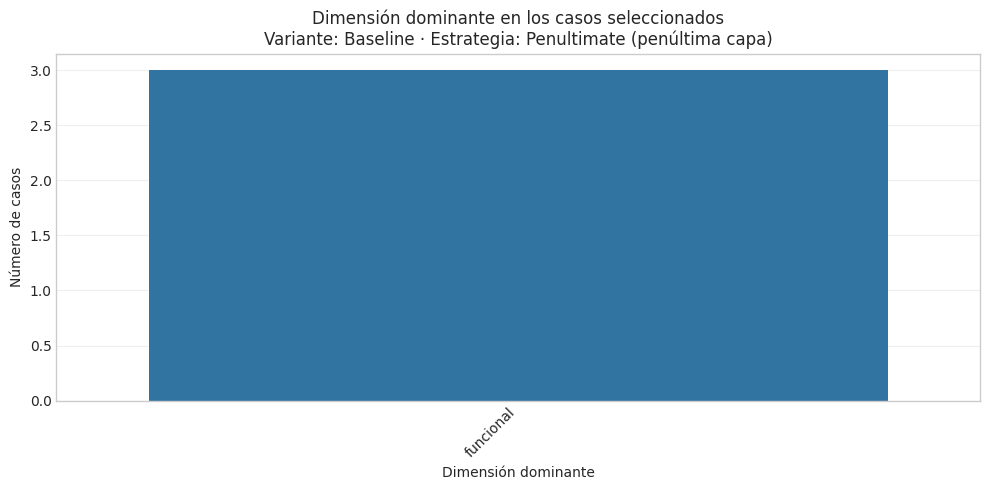

In [7]:
# --- 4. Matriz de Hipótesis 'Actor Social' (tabla + visualización opcional) ---

import numpy as np
import pandas as pd
import matplotlib as mpl
mpl.rcParams['font.family'] = 'DejaVu Sans'
import matplotlib.pyplot as plt
import seaborn as sns

# (Opcional) Etiquetas “humanas” para mostrar en resultados
variant_label_es = {"baseline": "Baseline", "dapt": "DAPT"}
strategy_label_es = {
    "penultimate": "Penultimate (penúltima capa)",
    "last4_concat": "Last4Concat (concat. 4 últimas capas)"
}

hypothesis_matrix = []

for _, case in cases_df.iterrows():
    win = case['window']
    row = df.loc[win]

    # 1) Persistencia (proxy):
    #    idea: si la deriva en la ventana siguiente es baja, “permanece” más.
    #    OJO: 1 - drift puede salir fuera de [0,1], por eso acotamos para interpretabilidad.
    idx_loc = df.index.get_loc(win)
    if idx_loc + 1 < len(df):
        next_drift = df.iloc[idx_loc + 1][f"drift_{target_v}_{target_s}"]
        persistence_proxy = float(np.clip(1.0 - next_drift, 0.0, 1.0))
    else:
        persistence_proxy = 0.5  # valor neutral si no hay ventana siguiente

    # 2) Dimensión dominante (según proyección del centroide)
    proj_vals = {d: row[f"centroid_proj_{d}_{target_v}_{target_s}"] for d in dims}
    dom_dim = max(proj_vals, key=proj_vals.get)

    # 3) “Coherencia” (en tu fórmula actual es una discrepancia):
    #    abs(subspace_alignment - abs(centroid_projection))
    #    Interpretación: 0 = más consistente; valores altos = más discrepancia.
    sub_val = row[f"subspace_proj_{dom_dim}_{target_v}_{target_s}"]
    cent_val = proj_vals[dom_dim]
    discrepancia_proxy = float(abs(sub_val - abs(cent_val)))

    # 4) Estado (tal como lo tenías: solo basado en persistencia)
    estado = "Hipótesis apoyada" if persistence_proxy > 0.5 else "Ambigua"

    hypothesis_matrix.append({
        "ventana": win.strftime('%Y-%m'),
        "dimensión_dominante": dom_dim,
        "persistencia_proxy": round(persistence_proxy, 3),
        "discrepancia_proxy": round(discrepancia_proxy, 3),
        "estado_actor_social": estado
    })

hyp_df = pd.DataFrame(hypothesis_matrix)

# Metadatos útiles (sin tocar tu lógica)
v_lbl = variant_label_es.get(target_v, target_v)
s_lbl = strategy_label_es.get(target_s, target_s)
hyp_df.insert(0, "variante", v_lbl)
hyp_df.insert(1, "estrategia", s_lbl)

hyp_df.to_csv(f"{TABLES_DIR}/44_social_actor_hypothesis.csv", index=False)
display(hyp_df)

# -----------------------------
# Visualización opcional (recomendable para legibilidad)
# -----------------------------
# 1) Dispersión: persistencia vs discrepancia, coloreando por estado
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=hyp_df,
    x="persistencia_proxy",
    y="discrepancia_proxy",
    hue="estado_actor_social",
    style="estado_actor_social",
    s=90,
    alpha=0.8
)
plt.title(
    "Matriz de hipótesis 'Actor social': relación entre persistencia y discrepancia\n"
    f"Variante: {v_lbl} · Estrategia: {s_lbl}"
)
plt.xlabel("Persistencia (proxy acotado 0–1; mayor = más persistente)")
plt.ylabel("Discrepancia (proxy; menor = más coherente)")
plt.grid(True, alpha=0.3)
plt.legend(title="Estado", frameon=False)
plt.tight_layout()
plt.savefig(f"{FIGURES_DIR}/44_social_actor_hypothesis_scatter.png")
plt.show()

# 2) Conteo de dimensiones dominantes (qué “domina” en casos)
plt.figure(figsize=(10, 5))
order_dims = hyp_df["dimensión_dominante"].value_counts().index.tolist()
sns.countplot(data=hyp_df, x="dimensión_dominante", order=order_dims)
plt.title(
    "Dimensión dominante en los casos seleccionados\n"
    f"Variante: {v_lbl} · Estrategia: {s_lbl}"
)
plt.xlabel("Dimensión dominante")
plt.ylabel("Número de casos")
plt.xticks(rotation=45, ha='right')
plt.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.savefig(f"{FIGURES_DIR}/44_social_actor_hypothesis_dims.png")
plt.show()


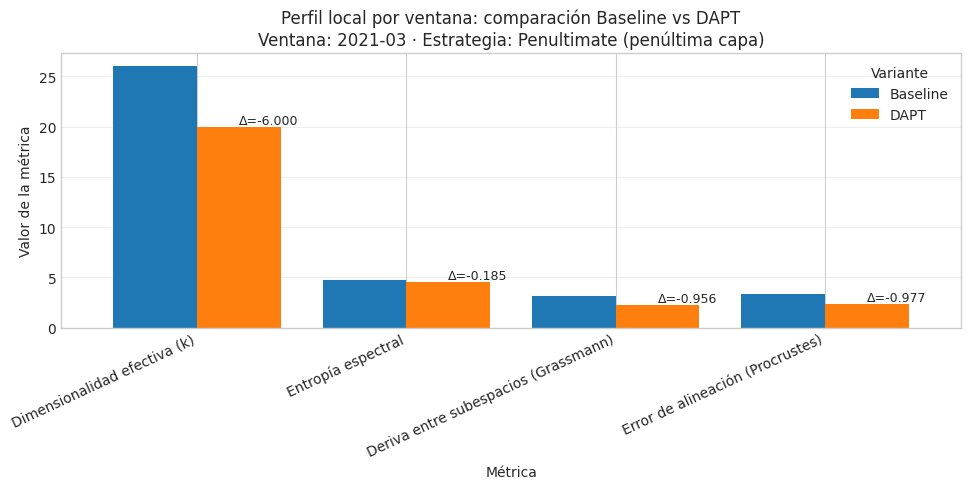

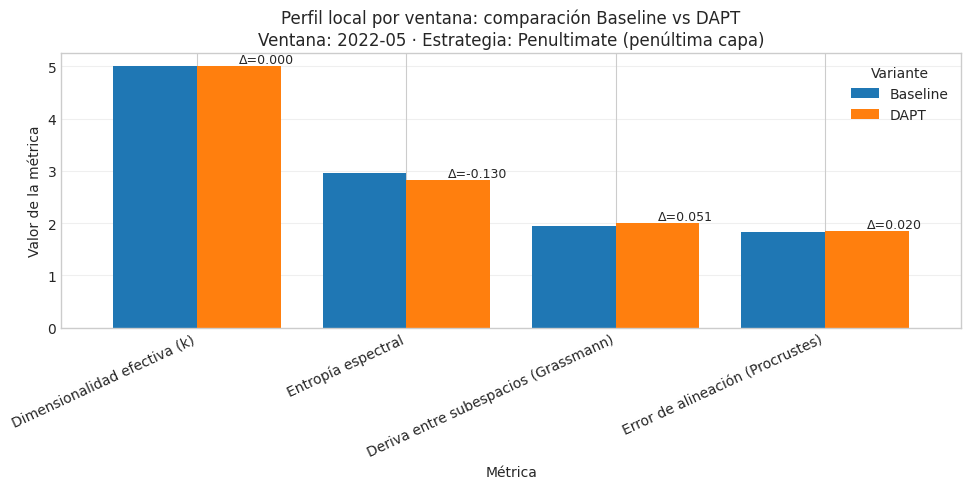

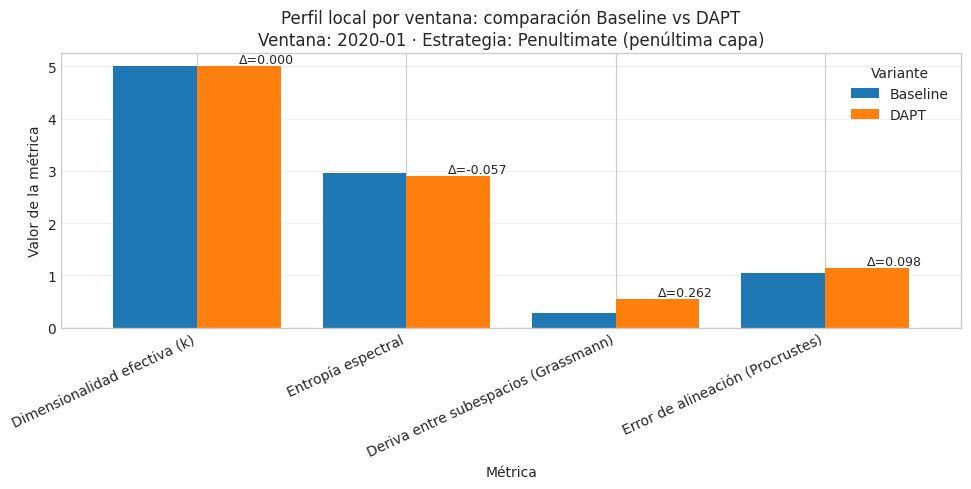

In [8]:
# --- 5. Baseline vs DAPT (Por Caso, gráfico legible en castellano) ---

import matplotlib as mpl
mpl.rcParams['font.family'] = 'DejaVu Sans'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Etiquetas descriptivas (solo para visualización)
metric_label_es = {
    "k": "Dimensionalidad efectiva (k)",
    "entropy": "Entropía espectral",
    "drift": "Deriva entre subespacios (Grassmann)",
    "procrustes": "Error de alineación (Procrustes)"
}
variant_label_es = {"baseline": "Baseline", "dapt": "DAPT"}
strategy_label_es = {
    "penultimate": "Penultimate (penúltima capa)",
    "last4_concat": "Last4Concat (concat. 4 últimas capas)"
}

if "dapt" in variants:
    for _, case in cases_df.iterrows():
        win = case['window']

        # Comparar métricas para esta ventana
        row = df.loc[win]

        comparison = {}
        for m in ['k', 'entropy', 'drift', 'procrustes']:
            b_val = row.get(f"{m}_baseline_{target_s}", np.nan)
            d_val = row.get(f"{m}_dapt_{target_s}", np.nan)
            comparison[m] = {
                "Baseline": b_val,
                "DAPT": d_val,
                "Delta (DAPT − Baseline)": d_val - b_val
            }

        comp_df = pd.DataFrame(comparison).T
        comp_df.index = [metric_label_es.get(idx, idx) for idx in comp_df.index]

        # Plot: barras lado a lado (Baseline vs DAPT)
        ax = comp_df[["Baseline", "DAPT"]].plot(kind='bar', figsize=(10, 5), width=0.8)

        v_lbl = variant_label_es.get("baseline", "Baseline")  # fijo aquí
        s_lbl = strategy_label_es.get(target_s, target_s)

        ax.set_title(
            "Perfil local por ventana: comparación Baseline vs DAPT\n"
            f"Ventana: {win.strftime('%Y-%m')} · Estrategia: {s_lbl}"
        )
        ax.set_xlabel("Métrica")
        ax.set_ylabel("Valor de la métrica")
        ax.grid(True, axis='y', alpha=0.3)
        ax.legend(title="Variante", frameon=False)

        # Añadir anotación de deltas en cada métrica (más interpretable)
        # (Se coloca sobre la barra de DAPT)
        for i, (idx, r) in enumerate(comp_df.iterrows()):
            delta = r["Delta (DAPT − Baseline)"]
            dapt_val = r["DAPT"]
            if np.isfinite(dapt_val) and np.isfinite(delta):
                ax.text(
                    i + 0.2, dapt_val,
                    f"Δ={delta:.3f}",
                    ha='left', va='bottom', fontsize=9
                )

        plt.xticks(rotation=25, ha='right')
        plt.tight_layout()
        plt.savefig(f"{FIGURES_DIR}/44_baseline_vs_dapt_case_{win.strftime('%Y-%m')}.png")
        plt.show()

else:
    print("No hay DAPT disponible para comparar.")
